![Plane departing the Pacific Northwest](IMG_8801.JPG)

A prominent airline company in the Pacific Northwest has accumulated extensive data related to flights and weather patterns and needs to understand the factors influencing the departure delays and cancellations to benefit both airlines and passengers. As the data analyst on the team, you decide to embark on this analytical project.

The aviation industry is dynamic with various variables impacting flight operations. To ensure the relevance and applicability of your findings, you choose to focus solely on flights from the 'pnwflights2022' datasets available from the ModernDive team exported as CSV files. These datasets provide comprehensive information on flights departing in the first half of 2022 from both of the two major airports in this region: SEA (Seattle-Tacoma International Airport) and PDX (Portland International Airport): 

- `flights2022.csv` contains information about about each flight including 

| Variable   | Description                                          |
|------------|------------------------------------------------------|
| `dep_time`   | Departure time (in the format hhmm) where`NA` corresponds to a cancelled flight        |
| `dep_delay`  | Departure delay, in minutes (negative for early)    |
| `origin`     | Origin airport where flight starts (IATA code)
| `airline`    | Carrier/airline name                        |
| `dest`       | Destination airport where flight lands (IATA code)  

- `flights_weather2022.csv` contains the same flight information as well as weather conditions such as 
 
| Variable   | Description                                           |
|------------|-------------------------------------------------------|
| `visib`      | Visibility (in miles)                                 |
| `wind_gust`  | Wind gust speed (in mph)  

Which airlines and routes (for example "PDX-SFO") are most affected by flight delays, and what impact does wind have on departure delays?

- Load the two CSV files into separate DataFrames. Explore the data and create any new columns that might benefit your analysis.
- For routes, calculate the average departure delays and highest number of canceled flights and store this as a DataFrame called routes_delays_cancels, resetting the index after calculating.
- For airlines, determine the average departure delays and the highest number of canceled flights and store this as a DataFrame called airlines_delays_cancels, resetting the index after calculating.
- Produce two bar graphs to show (1) the top 9 highest number of cancellations by route in a plot called top9_route_cancels_bar and (2) the top 9 highest average departure delays by airline in a plot called top9_airline_delays_bar.
- Determine if 10 mile per hour wind gusts or more have a larger average departure delay for both of SEA and PDX, setting wind_response to True if so and False if not.

In [ ]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

flights2022 = pd.read_csv("flights2022.csv")
flights_weather2022 = pd.read_csv("flights_weather2022.csv")

In [3]:
flights2022.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour,airline
0,2022,1,1,1.0,2359,2.0,604.0,618,-14.0,UA,555,N405UA,SEA,IAH,221.0,1874,23,59,2022-01-01T23:00:00Z,United Air Lines Inc.
1,2022,1,1,1.0,2250,71.0,242.0,142,60.0,AS,72,N265AK,SEA,FAI,193.0,1533,22,50,2022-01-01T22:00:00Z,Alaska Airlines Inc.
2,2022,1,1,10.0,2355,15.0,759.0,730,29.0,AS,270,N274AK,SEA,ATL,261.0,2182,23,55,2022-01-01T23:00:00Z,Alaska Airlines Inc.
3,2022,1,1,25.0,2350,35.0,606.0,550,16.0,AS,7,N281AK,SEA,ORD,193.0,1721,23,50,2022-01-01T23:00:00Z,Alaska Airlines Inc.
4,2022,1,1,35.0,2349,46.0,616.0,545,31.0,UA,507,N426UA,PDX,ORD,196.0,1739,23,49,2022-01-01T23:00:00Z,United Air Lines Inc.


### Pytanie 1

In [46]:
# For routes, calculate the average departure delays and highest number of canceled flights and store this as a DataFrame 
# called routes_delays_cancels, resetting the index after calculating
flights2022['schedule_dep_time'] = pd.to_datetime(flights2022['sched_dep_time'], format='%H%M', errors='coerce').dt.time
flights2022['route'] = flights2022['origin'] + ' - ' + flights2022['dest']


routes_delays_cancels = flights2022[['origin', 'dest', 'schedule_dep_time', 'dep_delay', 'dep_time', 'route']]
routes_delays_cancels.head()

,origin,dest,schedule_dep_time,dep_delay,dep_time,route
0,SEA,IAH,23:59:00,2.0,1.0,SEA - IAH
1,SEA,FAI,22:50:00,71.0,1.0,SEA - FAI
2,SEA,ATL,23:55:00,15.0,10.0,SEA - ATL
3,SEA,ORD,23:50:00,35.0,25.0,SEA - ORD
4,PDX,ORD,23:49:00,46.0,35.0,PDX - ORD


In [48]:
routes_delays_cancels_grouped = routes_delays_cancels.groupby('route').agg(
    mean_dep_delay = ('dep_delay', 'mean'),
    total_cancellations = ('dep_time', lambda x: x.isna().sum())
).reset_index()
routes_delays_cancels_grouped

,route,mean_dep_delay,total_cancellations
0,PDX - ABQ,1.098039,2
1,PDX - ANC,4.748936,4
2,PDX - ATL,7.020979,13
3,PDX - AUS,5.435374,5
4,PDX - BOI,5.136430,7
...,...,...,...
144,SEA - STS,6.782493,5
145,SEA - SUN,5.735537,5
146,SEA - TPA,6.537344,20
147,SEA - TUS,6.161290,13


In [72]:
# Identify routes with the highest mean departure delays
top_5_routes = routes_delays_cancels_grouped.sort_values('mean_dep_delay', ascending=False).head(5)
top_5_routes['route']

13     PDX - DSM
19     PDX - GRR
17     PDX - FLL
109    SEA - MIA
71     SEA - CLT
Name: route, dtype: object

In [71]:
# Identify routes with the highest number of cancellations
top_5_cancellations = routes_delays_cancels_grouped.nlargest(5, 'total_cancellations')
top_5_cancellations['route']

103    SEA - LAX
58     SEA - ANC
102    SEA - LAS
137    SEA - SFO
121    SEA - PDX
Name: route, dtype: object

### Pytanie 2

In [62]:
# For airlines, determine the average departure delays and the highest number of canceled flights and store this as a DataFrame 
# called airlines_delays_cancels, resetting the index after calculating

airlines_delays = flights2022[['airline', 'dep_delay', 'dep_time']]
airlines_delays.head()

,airline,dep_delay,dep_time
0,United Air Lines Inc.,2.0,1.0
1,Alaska Airlines Inc.,71.0,1.0
2,Alaska Airlines Inc.,15.0,10.0
3,Alaska Airlines Inc.,35.0,25.0
4,United Air Lines Inc.,46.0,35.0


In [64]:
airlines_delays_grouped = airlines_delays.groupby('airline').agg(
    avg_dep_delays = ('dep_delay', 'mean'),
    total_cancellations = ('dep_time', lambda x: x.isna().sum())
).reset_index()
airlines_delays_grouped.head()

,airline,avg_dep_delays,total_cancellations
0,Alaska Airlines Inc.,6.739282,1300
1,Allegiant Air,26.608696,6
2,American Airlines Inc.,20.129903,85
3,Delta Air Lines Inc.,10.648634,383
4,Frontier Airlines Inc.,14.355856,12


In [82]:
# Identify airlines with the highest mean departure delay
top_5_airline_delays = airlines_delays_grouped.sort_values('avg_dep_delays', ascending=False).head(5)

# Identify airlines with the highest number of cancellations
top_5_airline_cancellations = airlines_delays_grouped.sort_values('total_cancellations', ascending=False).head(5)

print(f"Top 5 airlines delays:\n{top_5_airline_delays['airline']}")
print(f"\nTop 5 airlines cancelattions:\n{top_5_airline_cancellations['airline']}")

Top 5 airlines delays:
7           JetBlue Airways
1             Allegiant Air
2    American Airlines Inc.
4    Frontier Airlines Inc.
9    Southwest Airlines Co.
Name: airline, dtype: object

Top 5 airlines cancelattions:
0      Alaska Airlines Inc.
3      Delta Air Lines Inc.
6               Horizon Air
8     SkyWest Airlines Inc.
9    Southwest Airlines Co.
Name: airline, dtype: object


### Pytanie 3

Text(0.5, 1.0, 'Top 5 Routes with the most cancellations')

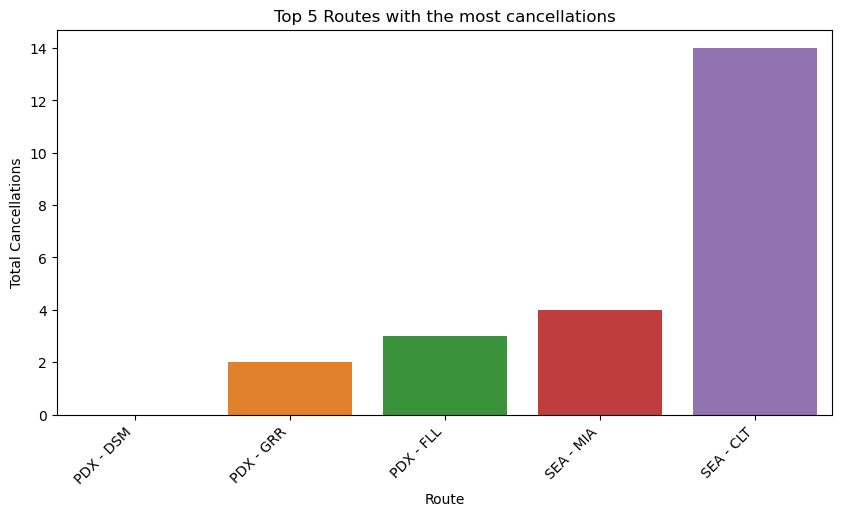

In [84]:
# Produce two bar graphs to show 
# (1) the top 9 highest number of cancellations by route in a plot called top9_route_cancels_bar and 
# (2) the top 9 highest average departure delays by airline in a plot called top9_airline_delays_bar.
import seaborn as sns

plt.figure(figsize=(10,5))
top5_route_cancels_bar = sns.barplot(
    data=top_5_routes,
    x='route',
    y='total_cancellations',
    hue='route'
    )
plt.xticks(rotation=45, ha='right')
plt.xlabel('Route')
plt.ylabel('Total Cancellations')
plt.title('Top 5 Routes with the most cancellations')


Text(0.5, 1.0, 'Average Departure Delays by Airline')

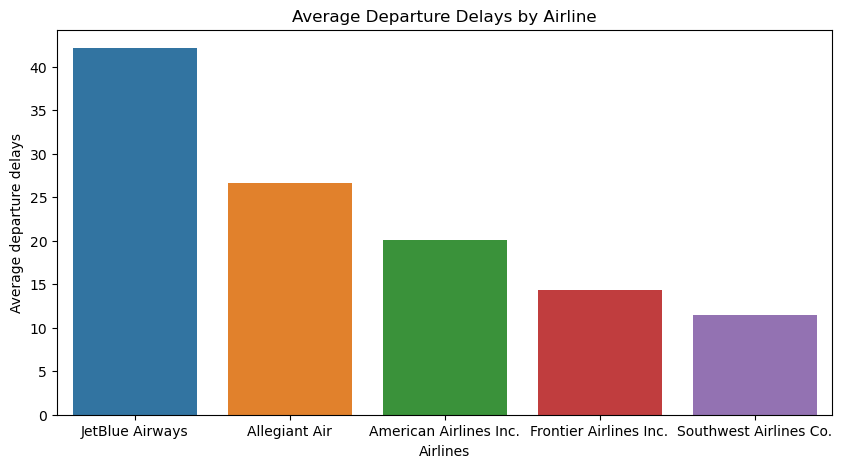

In [85]:
plt.figure(figsize=(10,5))
top_airline_avg_dep_delays = sns.barplot(
    data=top_5_airline_delays,
    x='airline',
    y='avg_dep_delays',
    hue='airline'
)

plt.xlabel('Airlines')
plt.ylabel('Average departure delays')
plt.title('Average Departure Delays by Airline')

### Pytanie 4

In [86]:
flights_weather2022.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,route,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib
0,2022,1,1,1.0,2359,2.0,604.0,618,-14.0,UA,...,SEA-IAH,33.0,23.0,66.06,160.0,8.05546,9.270062,0.0,1022.9,10.0
1,2022,1,1,1.0,2250,71.0,242.0,142,60.0,AS,...,SEA-FAI,32.0,23.0,69.04,170.0,9.20624,10.594357,0.0,1023.4,10.0
2,2022,1,1,10.0,2355,15.0,759.0,730,29.0,AS,...,SEA-ATL,33.0,23.0,66.06,160.0,8.05546,9.270062,0.0,1022.9,10.0
3,2022,1,1,25.0,2350,35.0,606.0,550,16.0,AS,...,SEA-ORD,33.0,23.0,66.06,160.0,8.05546,9.270062,0.0,1022.9,10.0
4,2022,1,1,35.0,2349,46.0,616.0,545,31.0,UA,...,PDX-ORD,33.0,19.0,55.75,120.0,6.90468,7.945768,0.0,1025.1,10.0


In [94]:
# Determine if 10 mile per hour wind gusts or more have a larger average departure delay 
# for both of SEA and PDX, setting wind_response to True if so and False if not


In [93]:
flights_weather2022["group"] = flights_weather2022["wind_gust"].apply(lambda x: ">= 10mph" if x >= 10 else "< 10 mph")
wind_grouped_data = flights_weather2022.groupby(["group", "origin"]).agg(
    mean_dep_delay=("dep_delay", "mean")
)

print(wind_grouped_data)

                 mean_dep_delay
group    origin                
< 10 mph PDX           6.686966
         SEA           7.857595
>= 10mph PDX           9.147024
         SEA           9.231060


# Solution

In [ ]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
flights2022 = pd.read_csv("flights2022.csv")
flights_weather2022 = pd.read_csv("flights_weather2022.csv")

# Create route column
flights2022["route"] = flights2022["origin"] + "-" + flights2022["dest"]

# Calculate mean departure delay and number of canceled flights for each unique flight route
routes_delays_cancels = flights2022.groupby("route").agg(
    mean_dep_delay=("dep_delay", "mean"),
    total_cancellations=("dep_time", lambda x: x.isna().sum())
).reset_index()

# Identify routes with the highest mean departure delays
top_routes_by_delay = routes_delays_cancels.sort_values("mean_dep_delay", ascending=False).head(9)

# Identify routes with the highest number of cancellations
top_routes_by_cancellations = routes_delays_cancels.sort_values("total_cancellations", ascending=False).head(9)

# Create a bar graph for highest number of cancellations
top9_route_cancels_bar, ax = plt.subplots()
ax.bar(top_routes_by_cancellations["route"], top_routes_by_cancellations["total_cancellations"])
ax.set_xlabel("Route")
ax.set_ylabel("Total Cancellations")
ax.set_title("Routes with Highest Number of Cancellations")
ax.set_xticklabels(top_routes_by_cancellations["route"], rotation=90)
plt.show()
plt.close()

# Find mean departure delays and total cancellations by airline
airlines_delays_cancels = flights2022.groupby("airline").agg(
    mean_dep_delay=("dep_delay", "mean"),
    total_cancellations=("dep_time", lambda x: x.isna().sum())
).reset_index()

# Identify airlines with the highest mean departure delay
top_airlines_by_delay = airlines_delays_cancels.sort_values("mean_dep_delay", ascending=False).head(9)

# Identify airlines with the highest number of cancellations
top_airlines_by_cancellations = airlines_delays_cancels.sort_values("total_cancellations", ascending=False).head(9)

# Create a bar graph for highest mean depearture delay
top9_airline_delays_bar, ax = plt.subplots()
ax.bar(top_airlines_by_delay["airline"], top_airlines_by_delay["mean_dep_delay"])
ax.set_xlabel("Airline")
ax.set_ylabel("Mean Departure Delay")
ax.set_title("Airlines with Highest Mean Departure Delays")
ax.set_xticklabels(top_airlines_by_delay["airline"], rotation=90)
plt.show()

# Are departure delays impacted by 10+ mph winds from each airport
flights_weather2022["group"] = flights_weather2022["wind_gust"].apply(lambda x: ">= 10mph" if x >= 10 else "< 10 mph")
wind_grouped_data = flights_weather2022.groupby(["group", "origin"]).agg(
    mean_dep_delay=("dep_delay", "mean")
)

print(wind_grouped_data)

wind_response = True